In [1]:
!pip3 install pulp

In [2]:
import pandas as pd
import pulp
import numpy as np
import datetime
import matplotlib.pyplot as plt 

## Q2

In [3]:
df_distance = pd.read_csv("distances.csv")
df_2A = pd.read_csv("part2_ordersA.csv")
df_2B = pd.read_csv("part2_ordersB.csv")

In [4]:
# test orders (feel free the comment and uncomment below section for the dataset needed)

df_2 = df_2A
start_time = pd.to_datetime('2022-04-02 19:00:00')
W = 200 # minimum distance occurs at W > 70.5, solutions become infeasible when W < 13
W_range = range(80, 200, 10)

#################################################################################################################

# df_2 = df_2B
# start_time = pd.to_datetime('2022-04-02 17:00:00')
# W = 150 # minimum distance occurs at W > 81.5, solutions become infeasible when W < 38
# W_range = range(80, 250, 10)

In [5]:
df_2

,restaurant,customer,estimated availability
0,Scarborough (Kennedy Park / Ionview / East Bir...,Scarborough (Woburn),2022-04-02 7:27 PM
1,Central Toronto (North Toronto West),Etobicoke (Westmount),2022-04-02 8:30 PM


### Sets

In [6]:
start = list(df_2["restaurant"].unique()) + list(df_2["customer"].unique())
start.append("Downtown Toronto (Rosedale)")
start = list(dict.fromkeys(start))
start

['Scarborough (Kennedy Park / Ionview / East Birchmount Park)',
 'Central Toronto (North Toronto West)',
 'Scarborough (Woburn)',
 'Etobicoke (Westmount)',
 'Downtown Toronto (Rosedale)']

In [7]:
end = list(df_2["restaurant"].unique()) + list(df_2["customer"].unique())
end = list(dict.fromkeys(end))
end

['Scarborough (Kennedy Park / Ionview / East Birchmount Park)',
 'Central Toronto (North Toronto West)',
 'Scarborough (Woburn)',
 'Etobicoke (Westmount)']

In [8]:
step = np.arange(0, len(end)).tolist()
step

[0, 1, 2, 3]

In [9]:
restaurants = df_2["restaurant"].unique().tolist()
restaurants

['Scarborough (Kennedy Park / Ionview / East Birchmount Park)',
 'Central Toronto (North Toronto West)']

In [10]:
customers = df_2["customer"].unique().tolist()
customers

['Scarborough (Woburn)', 'Etobicoke (Westmount)']

In [11]:
list_order = []
for index, row in df_2.iterrows():
    list_order.append([row["restaurant"], row["customer"]])
print(list_order)

[['Scarborough (Kennedy Park / Ionview / East Birchmount Park)', 'Scarborough (Woburn)'], ['Central Toronto (North Toronto West)', 'Etobicoke (Westmount)']]


### Parameters

In [12]:
location_distance = {}
for i in start:
    for j in end: 
        if i == j:
            location_distance[(i,j)] = 0 
        else:
            location_distance[(i,j)] = float(df_distance[(df_distance["origin"] == i)&(df_distance["destination"] == j)]["distance"])

In [13]:
min_arrival_time_mins = {}
for j in end:
    if j in restaurants:
        delta = pd.to_datetime(df_2.loc[df_2["restaurant"] == j]["estimated availability"].tolist()[0]) - start_time
        min_arrival_time_mins[j] = delta/datetime.timedelta(minutes=1)
    if j in customers: 
        #delta = pd.to_datetime(df_2.loc[df_2["customer"] == j]["estimated availability"].tolist()[0]) - start_time
        #min_arrival_time_mins[j] = delta/datetime.timedelta(minutes=1)
        min_arrival_time_mins[j] = 0 
min_arrival_time_mins

{'Scarborough (Kennedy Park / Ionview / East Birchmount Park)': 27.0,
 'Central Toronto (North Toronto West)': 90.0,
 'Scarborough (Woburn)': 0,
 'Etobicoke (Westmount)': 0}

In [14]:
wait_time = 5
velocity = 3/2 # 40 km/h = 3/2 km/min
travel_time = {}
for i in start:
    for j in end:
        if i == j:
            travel_time[(i,j)] = 0 
        else: 
            if i in customers:
                travel_time[(i,j)] = location_distance[(i,j)]*velocity + wait_time
            else:
                travel_time[(i,j)] = location_distance[(i,j)]*velocity 

### Variables

In [15]:
xvar = pulp.LpVariable.dict("x", (start, end, step), cat=pulp.LpBinary)
dvar = pulp.LpVariable.dict("d", step, lowBound=0.0, cat=pulp.LpContinuous)
wvar = pulp.LpVariable.dict("w", (end, step), lowBound=0.0, cat=pulp.LpContinuous)
zvar = pulp.LpVariable.dict("z", step, lowBound=0.0, cat=pulp.LpContinuous)

In [16]:
df_2

,restaurant,customer,estimated availability
0,Scarborough (Kennedy Park / Ionview / East Bir...,Scarborough (Woburn),2022-04-02 7:27 PM
1,Central Toronto (North Toronto West),Etobicoke (Westmount),2022-04-02 8:30 PM


In [17]:
min_arrival_time_mins

{'Scarborough (Kennedy Park / Ionview / East Birchmount Park)': 27.0,
 'Central Toronto (North Toronto West)': 90.0,
 'Scarborough (Woburn)': 0,
 'Etobicoke (Westmount)': 0}

### Model & Constraints

In [18]:
flowmodel = pulp.LpProblem(name = "FlowModel", sense = pulp.LpMinimize)

# Constraint: every location visited once
for j in end: 
    flowmodel += pulp.lpSum([xvar[(i,j,t)] for i in start for t in step]) == 1
    
    
# Constraint: Convervation of flow
for t in step[:-1]:
    for j in end:
        flowmodel += (pulp.lpSum([xvar[(i,j,t)] for i in start]) == pulp.lpSum([xvar[(j,k,t+1)] for k in end]))

        
# Constraint: First node (Rosedale) has an outflow of 1 in the first step, others are zero
for i in start:
    if i == "Downtown Toronto (Rosedale)":
        flowmodel += pulp.lpSum([xvar[(i,j,0)] for j in end]) == 1
    else: 
        flowmodel += pulp.lpSum([xvar[(i,j,0)] for j in end]) == 0

        
def find_restaurant_of_customer(customer):
    for order in list_order:
        if customer == order[1]:
            return order[0]
        
# Constraint: make sure driver goes to a restaurant before delivering the food
for t in step: 
    for j in end: 
        if j in customers: 
            flowmodel += pulp.lpSum( [xvar[i,j,t] for i in start]) <= pulp.lpSum([xvar[i, find_restaurant_of_customer(j),t_] for i in start for t_ in step[:t]])
        

# Constraint: Time to arrive at the location of the t-th step
for t in step:
    if t == 0: 
        flowmodel += dvar[t] == pulp.lpSum([ xvar[(i,j,0)] * min_arrival_time_mins[j] for i in start for j in end])
    else:
        flowmodel += dvar[t] >= (dvar[t-1] + pulp.lpSum([ xvar[(i,j,t)] * travel_time[(i,j)] for i in start for j in end]))


        
# Constraint: if arriving at location j, ensures time is at least the min_arrival_time_mins
for t in step:
    for i in start:
        for j in end:
            flowmodel += dvar[t] >= min_arrival_time_mins[j] * xvar[i,j,t]
          
        
# Constraint: define waiting time of each order at step t: wvar[j,t]
for t in step:
    for j in end:
        if j in restaurants:
            flowmodel += wvar[(j,t)]  == 0
        else:
            flowmodel += wvar[(j,t)] == dvar[t] - pulp.lpSum([ min_arrival_time_mins[find_restaurant_of_customer(j)] * xvar[(i,j,t)] for i in start])

            
# # # Constraint: ensures the average waiting time of the orders is lower than the maximum W

# # implementation idea: 
# #         flowmodel += pulp.lpSum([wvar[j,t] * xvar[i,j,t] for i in start]) <= W
# # use zvar[t] with big Constant M to denote wvar[j,t] * xvar[i,j,t] as two decision variables cannot be multiplied together
# # zvar[t] is the total waiting time up until the step t

# M = 500000
# for t in step:
#     for i in start:
#         for j in end:
#             if t == 0:
#                 flowmodel += zvar[t] == 0 
#             elif t == 1:
#                 flowmodel += zvar[t] >= wvar[j,t] - M * (1 - xvar[(i,j,t)])
#                 flowmodel += zvar[t] <= wvar[j,t] + M * (1 - xvar[(i,j,t)])
#             else: 
#                 flowmodel += zvar[t] >= zvar[t-1] + wvar[(j,t)] - M * (1 - xvar[(i,j,t)])
#                 flowmodel += zvar[t] <= zvar[t-1] + wvar[(j,t)] + M * (1 - xvar[(i,j,t)])


# New Measure: Instead of using the averge, we put on the constraint on the waiting time for each customer 
for t in step:
    for j in end:
        flowmodel += wvar[(j,t)] <= W


#### 1. How much more difficult does the problem become as W decreases or increases? Why?

As W increases, the problem becomes harder as we will be sacrifacing more distances in order to get a feasible solution and meet the maximum average waiting time for each customer. 

#### 3. What is the problem when considering the average waiting time? Propose and test an alternative metric to address the issue you identified, showing how the solution changed with your new measure.
Average waiting time will averge out the extreme cases so that different customers might get very different delivering experiences. Another metric we propose is the waiting time for each customer. (or could be something else)

### Objective Functions

In [19]:
obj = pulp.lpSum([location_distance[(i,j)] * xvar[(i,j,t)] for i in start for j in end for t in step])
flowmodel += obj

### Solution Process

In [20]:
flowmodel.solve()
print("Status:", pulp.LpStatus[flowmodel.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/0d704ada420845d0b65dd3ec91ec60fa-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/0d704ada420845d0b65dd3ec91ec60fa-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 150 COLUMNS
At line 948 RHS
At line 1094 BOUNDS
At line 1175 ENDATA
Problem MODEL has 145 rows, 100 columns and 573 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.795 - 0.00 seconds
Cgl0002I 18 variables fixed
Cgl0003I 30 fixed, 0 tightened bounds, 17 strengthened rows, 5 substitutions
Cgl0003I 7 fixed, 0 tightened bounds, 1 strengthened rows, 4 substitutions
Cgl0003I 1 fixed, 0 tightened bounds, 1 strengthened rows, 3 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 

In [21]:
# Total Distance
totalDistance = pulp.value(flowmodel.objective)
print("Total Distance: " + str(totalDistance))

Total Distance: 42.7683943351618


In [22]:
# print solution
for t in step: 
    print("Step: " + str(t))
    print("Total travel time (in minutes) up to this step: " + str(dvar[t].varValue))
    
    for i in start: 
        for j in end: 
            
            if xvar[(i,j,t)].varValue > 0.0:
                print("\tLeave from " + str(i))
                print("\tTravel to " + str(j))
                print("\tWaiting time: " + str(wvar[(j,t)].varValue))
                #print("\tTotal waiting time up to this step: " + str(zvar[t].varValue))
                
#print("Average waiting time: " + str(zvar[t].varValue/len(customers)))


Step: 0
Total travel time (in minutes) up to this step: 90.0
	Leave from Downtown Toronto (Rosedale)
	Travel to Central Toronto (North Toronto West)
	Waiting time: 0.0
Step: 1
Total travel time (in minutes) up to this step: 105.50979
	Leave from Central Toronto (North Toronto West)
	Travel to Etobicoke (Westmount)
	Waiting time: 15.509793
Step: 2
Total travel time (in minutes) up to this step: 143.3877
	Leave from Etobicoke (Westmount)
	Travel to Scarborough (Kennedy Park / Ionview / East Birchmount Park)
	Waiting time: 0.0
Step: 3
Total travel time (in minutes) up to this step: 200.0
	Leave from Scarborough (Kennedy Park / Ionview / East Birchmount Park)
	Travel to Scarborough (Woburn)
	Waiting time: 173.0


In [23]:
df_2

,restaurant,customer,estimated availability
0,Scarborough (Kennedy Park / Ionview / East Bir...,Scarborough (Woburn),2022-04-02 7:27 PM
1,Central Toronto (North Toronto West),Etobicoke (Westmount),2022-04-02 8:30 PM


### Loop through W 

In [24]:
def get_distance(W):
    flowmodel = pulp.LpProblem(name = "FlowModel", sense = pulp.LpMinimize)

    # Constraint: every location visited once
    for j in end: 
        flowmodel += pulp.lpSum([xvar[(i,j,t)] for i in start for t in step]) == 1


    # Constraint: Convervation of flow
    for t in step[:-1]:
        for j in end:
            flowmodel += (pulp.lpSum([xvar[(i,j,t)] for i in start]) == pulp.lpSum([xvar[(j,k,t+1)] for k in end]))


    # Constraint: First node (Rosedale) has an outflow of 1 in the first step, others are zero
    for i in start:
        if i == "Downtown Toronto (Rosedale)":
            flowmodel += pulp.lpSum([xvar[(i,j,0)] for j in end]) == 1
        else: 
            flowmodel += pulp.lpSum([xvar[(i,j,0)] for j in end]) == 0


    def find_restaurant_of_customer(customer):
        for order in list_order:
            if customer == order[1]:
                return order[0]

    # Constraint: make sure driver goes to a restaurant before delivering the food
    for t in step: 
        for j in end: 
            if j in customers: 
                flowmodel += pulp.lpSum( [xvar[i,j,t] for i in start]) <= pulp.lpSum([xvar[i, find_restaurant_of_customer(j),t_] for i in start for t_ in step[:t]])


    # Constraint: Time to arrive at the location of the t-th step
    for t in step:
        if t == 0: 
            flowmodel += dvar[t] == pulp.lpSum([ xvar[(i,j,0)] * min_arrival_time_mins[j] for i in start for j in end])
        else:
            flowmodel += dvar[t] >= (dvar[t-1] + pulp.lpSum([ xvar[(i,j,t)] * travel_time[(i,j)] for i in start for j in end]))



    # Constraint: if arriving at location j, ensures time is at least the min_arrival_time_mins
    for t in step:
        for i in start:
            for j in end:
                flowmodel += dvar[t] >= min_arrival_time_mins[j] * xvar[i,j,t]


    # Constraint: define waiting time of each order at step t: wvar[j,t]
    for t in step:
        for j in end:
            if j in restaurants:
                flowmodel += wvar[(j,t)]  == 0
            else:
                flowmodel += wvar[(j,t)] == dvar[t] - pulp.lpSum([ min_arrival_time_mins[find_restaurant_of_customer(j)] * xvar[(i,j,t)] for i in start])


#     # # Constraint: ensures the average waiting time of the orders is lower than the maximum W

#     # implementation idea: 
#     #         flowmodel += pulp.lpSum([wvar[j,t] * xvar[i,j,t] for i in start]) <= W
#     # use zvar[t] with big Constant M to denote wvar[j,t] * xvar[i,j,t] as two decision variables cannot be multiplied together
#     # zvar[t] is the total waiting time up until the step t

#     M = 500000
#     for t in step:
#         for i in start:
#             for j in end:
#                 if t == 0:
#                     flowmodel += zvar[t] == 0 
#                 elif t == 1:
#                     flowmodel += zvar[t] >= wvar[j,t] - M * (1 - xvar[(i,j,t)])
#                     flowmodel += zvar[t] <= wvar[j,t] + M * (1 - xvar[(i,j,t)])
#                 else: 
#                     flowmodel += zvar[t] >= zvar[t-1] + wvar[(j,t)] - M * (1 - xvar[(i,j,t)])
#                     flowmodel += zvar[t] <= zvar[t-1] + wvar[(j,t)] + M * (1 - xvar[(i,j,t)])


    # New Measure: Instead of using the averge, we put on the constraint on the waiting time for each customer 
    for t in step:
        for j in end:
            flowmodel += wvar[(j,t)] <= W

        
    obj = pulp.lpSum([location_distance[(i,j)] * xvar[(i,j,t)] for i in start for j in end for t in step])
    flowmodel += obj 
    
    optimal = flowmodel.solve()
    #print(optimal)

    if optimal == 1:
        return pulp.value(flowmodel.objective)
    else:
        return 0 


In [25]:
distance_list = []

for W in W_range:
    distance_list.append(get_distance(W))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/15c5fa4c131948d68b88b60f55d7e5e9-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/15c5fa4c131948d68b88b60f55d7e5e9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 150 COLUMNS
At line 948 RHS
At line 1094 BOUNDS
At line 1175 ENDATA
Problem MODEL has 145 rows, 100 columns and 573 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.795 - 0.00 seconds
Cgl0002I 18 variables fixed
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line -

In [26]:
distance_list

[0,
 0,
 0,
 43.3158014855584,
 43.3158014855584,
 43.3158014855584,
 43.3158014855584,
 43.3158014855584,
 42.7683943351618,
 42.7683943351618,
 42.7683943351618,
 42.7683943351618]

Text(0.5, 1.0, 'Trade-off Curve')

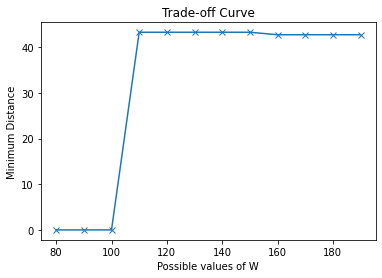

In [27]:
plt.plot(W_range, distance_list, marker='x')
plt.xlabel("Possible values of W")
plt.ylabel("Minimum Distance")
plt.title("Trade-off Curve")